# Laboratorio: Reti Neurali con Keras

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

Per questa esercitazione utilizziamo

- **Keras** come API di alto livello per la costruzione e l'addestramento di reti neurali
- **TensorFlow** come backend per la computazione da utilizzare attraverso Keras _(usiamo l'API Keras integrata dentro a TensorFlow)_

Se si lavora sul proprio PC, installare le librerie con `conda` oppure `pip` _(su Colab sono già installate)_

In [1]:
# se si utilizza Anaconda:
#%conda install tensorflow

In [2]:
# altrimenti:
#%pip install tensorflow

Importare TensorFlow per verificarne il funzionamento (`tf` è l'alias convenzionale con cui viene usato)

In [3]:
import tensorflow as tf

2024-05-27 11:59:19.409862: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 11:59:19.410024: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 11:59:19.412158: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 11:59:19.438423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 11:59:19.936958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Importiamo le altre librerie di uso comune

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

Definiamo la seguente funzione di supporto per scaricare i file di dati necessari

In [5]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Ripasso: Reti neurali

Una _rete neurale_ è un modello di apprendimento costituito da molteplici strati di nodi elementari

Ciascun nodo è in pratica un modello di regressione, i cui input sono forniti dallo strato precedente e il cui output è passato a quello successivo

Per modellare relazioni non lineari si applicano agli output dei nodi delle _funzioni di attivazione_, ad es. la funzione _ReLU_

Tramite la _backpropagation_, i parametri (pesi e bias) di tutti i nodi sono addestrati congiuntamente per ottimizzare l'errore della rete tramite discesa gradiente stocastica: il training set è iterato molteplici volte (_epoche_), ad ogni iterazione le istanze vengono considerate a gruppi (_minibatch_)

Ci sono molti aspetti configurabili (_iperparametri_) nella configurazione e nell'addestramento di una rete
- struttura della rete: numero di strati, numero di nodi in ciascuno, funzione di attivazione, ...
- addestramento: batch size, numero di epoche, ...

## Regressione con reti neurali

Le reti neurali sono in primis modelli di regressione, in quanto forniscono in output un valore reale (o più d'uno)

Vediamo un esempio concreto di uso di una rete neurale in un problema di regressione

Riprendiamo il problema della predizione dei consumi elettrici in base alla temperatura

Carichiamo il dataset in un frame pandas

In [6]:
POWER_URL = "https://github.com/datascienceunibo/dialab2024/raw/main/Regressione_Lineare/power.csv"

download("power.csv", POWER_URL)
data = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [7]:
data.head(5)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


Ricordiamo che anche in questo caso la relazione tra i dati è non lineare

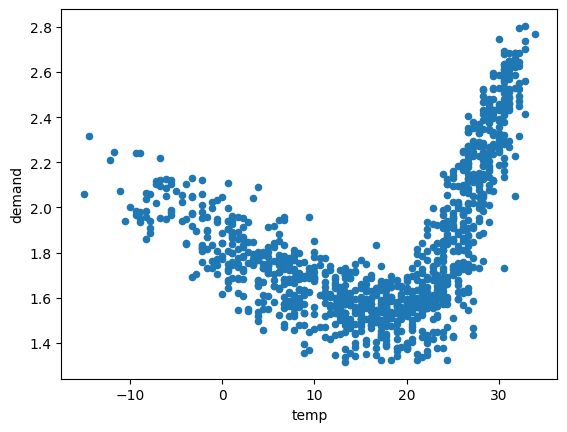

In [8]:
data.plot.scatter("temp", "demand");

Come in precedenza consideriamo i dati del 2015 e del 2016 come training set e quelli del 2017 come validation set

Per ogni set estraiamo le temperature registrate (variabile indipendente x) e i consumi (variabile dipendente y)

In [9]:
is_train = data.index.year < 2017
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

Eseguiamo la standardizzazione sia delle X che delle y (non utilizziamo una pipeline per analizzare meglio i passaggi)

In [10]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values[:, None]).ravel()
y_val = y_scaler.transform(y_val.values[:, None]).ravel()

Per addestrare un modello di regressione basato su rete neurale, utilizziamo la classe `MLPRegressor`

Questa classe supporta gli stessi iperparametri di `MLPClassifier`

Definiamo ad esempio una rete con 4 nodi nascosti con attivazione ReLU

In [11]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

Addestriamo il modello come al solito

In [12]:
model.fit(X_train, y_train);

/home/pasolini/.venvs/dia/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
model.score(X_val, y_val)

0.651189449215087

Riprendiamo la funzione utilizzata in precedenza per visualizzare le predizioni del modello sovrapposte ai dati

In [14]:
def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (normalizzata)"); plt.ylabel("Consumi (normalizzati)")

Usiamola per visualizzare il modello addestrato

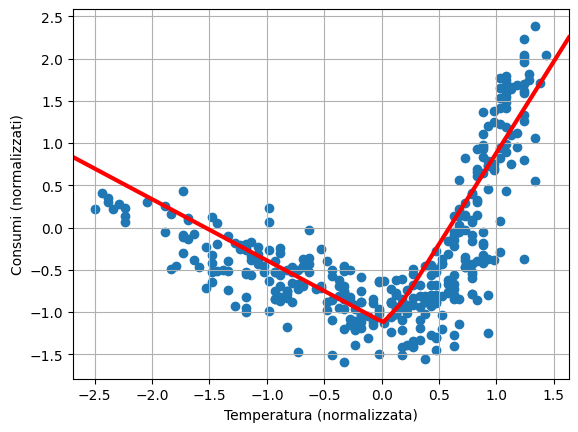

In [15]:
plot_model_on_data(X_val, y_val, model)

Con i nodi ReLU abbiamo ottenuto in pratica una funzione "spezzata"

## Reti neurali con Keras

Abbiamo visto il supporto basilare offerto da scikit-learn per addestrare reti neurali

Vediamo ora come utilizzare la libreria Keras, che offre

- maggiore flessibilità, con la possibilità di configurare nel dettaglio ciascuno strato della rete
- maggiore efficienza, utilizzando backend come TensorFlow con possibilità di utilizzo della GPU

## Modello di regressione con Keras

Continuiamo a considerare il problema di predizione dei consumi, per cui ci serve un modello di regressione

Un modello _sequenziale_ di Keras è definito da una sequenza (senza diramazioni, cicli, ecc.) di strati connessi

- il primo strato riceve l'input dato alla rete
- ogni strato propaga l'output allo strato successivo
- l'ultimo strato fornisce l'output della rete

Si definisce con un oggetto `Sequential` definendo la lista di strati

Come tipi di strati nel modello al momento consideriamo i seguenti:

- `Input`, lo strato iniziale della rete che rappresenta i dati forniti in input;
- `Dense`, il tipo di strato più comune, in cui ogni nodo riceve input da tutti i nodi dello strato precedente

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

Come test iniziale, creiamo una "rete" con un singolo strato e un singolo nodo

Come primo strato inseriamo un `Input` indicando la forma (_shape_) di ciascuna osservazione in input alla rete, in questo caso `(1,)` per indicare un vettore con un solo valore, ovvero la temperatura

A questo facciamo seguire un singolo strato `Dense`, indicando come parametro il numero di nodi, in questo caso 1

Lo strato `Dense`, essendo l'ultimo della sequenza, è implicitamente lo strato che fornisce l'output della rete

In [17]:
model = Sequential([
    Input((1,)),
    Dense(1),
])

L'output della rete sarà il valore restituito dal singolo nodo: questo è in pratica un semplice modello di regressione lineare univariata

Col metodo `summary` vediamo un riepilogo degli strati della rete

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

La `Output shape` indica la forma dell'output di ciascuno strato

- il primo termine (`None`) si riferisce al numero di osservazioni in ciascun minibatch, che è variabile
- il secondo termine (1) è dato dal numero di nodi specificato

`Param #` indica il numero di parametri che saranno addestrati, in questo caso solamente 2: 1 peso w e 1 bias b ($y=w\cdot x+b$)

Una volta definita la struttura della rete questa va _compilata_ per costruirne il grafo computazionale su TensorFlow

Quando si compila la rete va specificato un algoritmo di ottimizzazione (`optimizer`) da utilizzare per addestrare la rete: si possono usare diverse varianti della discesa gradiente stocastica

Va inoltre specificata la misura di errore (`loss`) da minimizzare nell'addestramento: per la regressione usiamo l'errore quadratico medio

In [19]:
model.compile(optimizer="adam", loss="mean_squared_error")

Ora possiamo addestrare la rete sul training set, usando il metodo `fit` come in scikit-learn, passando la matrice X con variabili indipendenti e il vettore y con la variabile dipendente da predire

Nella discesa gradiente stocastica gli esempi di training sono presi a gruppi di dimensione pari ad una `batch_size` indicata

L'intero training set viene scorso in ordine casuale per un numero cicli di addestramento, detti _epoche_ (`epochs`)

In [20]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 2.5732
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2.0884
[...]
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.8902
Epoch 20/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.8428


Durante l'addestramento, l'errore sul training set, mostrato come `loss`, si riduce progressivamente

L'andamento di epoca in epoca viene salvato nell'oggetto `fit_history`, possiamo visualizzarlo in un grafico

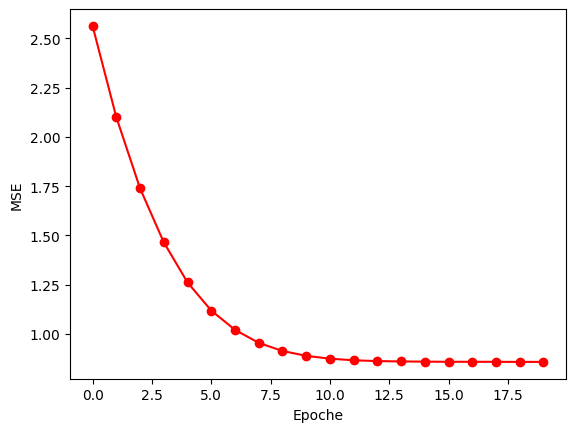

In [21]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

Una volta addestrato, possiamo ottenere predizioni dal modello col metodo `predict` come in scikit-learn

Otteniamo ad esempio le predizioni per il validation set

In [22]:
y_pred = model.predict(X_val)
y_pred[:3]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[-0.35106686],
       [-0.2964799 ],
       [-0.2589514 ]], dtype=float32)

Si noti che i valori restituiti dal modello sono standardizzati sulla stessa scala usata nell'addestramento

Possiamo usare il metodo `inverse_transform` del filtro per "destandardizzare" i valori riportandoli alla scala originale

In [23]:
y_scaler.inverse_transform(y_pred)[:3]

array([[1.7416204],
       [1.7603672],
       [1.7732555]], dtype=float32)

Il metodo `evaluate` esegue una valutazione su un validation set e restituisce la misura d'errore usata in addestramento (il MSE)

In [24]:
model.evaluate(X_val, y_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.6447


0.689818263053894

Questa misura può essere confrontata tra diversi modelli

Per ottenere una misura più generale dell'errore possiamo estrarre il coefficiente R², lo stesso restituito dal metodo `score` dei modelli di regressione di scikit-learn

In [25]:
from sklearn.metrics import r2_score
r2_score(
    y_scaler.inverse_transform(y_val[:, None]),
    y_scaler.inverse_transform(y_pred)
)

0.029321898239672683

Data la definizione di R², otteniamo lo stesso risultato confrontando gli output standardizzati

In [26]:
r2_score(y_val, y_pred)

0.02932188657369772

Il punteggio R² è prossimo allo 0, molto scarso

Questo è dovuto al fatto che il modello lineare non può modellare correttamente la relazione non lineare, come mostrato dal grafico del modello

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


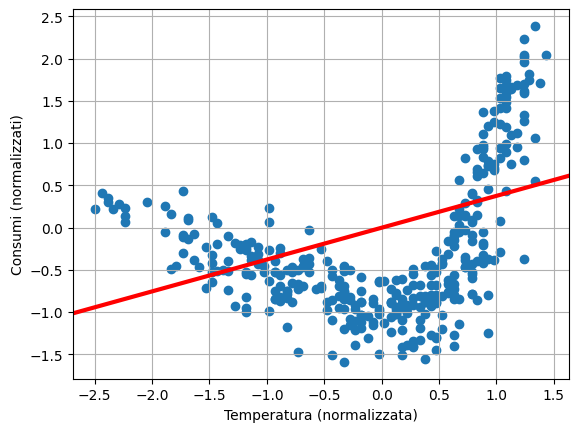

In [27]:
plot_model_on_data(X_val, y_val, model)

### Aggiungere uno strato

Aggiungiamo ora al modello uno strato nascosto - ad es. di 8 nodi - a cui viene passato l'input

Per introdurre non linearità, a questo strato applichiamo la funzione di attivazione ReLU

Siano

- $w^{(l)}_{i,j}$ il peso della connessione dal nodo $i$ dello strato $l-1$ al nodo $j$ dello strato $l$
- $b^{(l)}_j$ il bias applicato sul nodo $j$ dello strato $l$

Ogni nodo dello strato nascosto $i$ fornirà come output:

$$ h_i = \text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right) $$

A sua volta l'output sarà una combinazione di questi 8 nodi:

$$ y = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i1}\cdot h_i} = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i,1}\cdot\text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right)} $$

Creiamo un nuovo modello `Sequential` con uno strato `Dense` aggiunto con attivazione "relu"

Lo strato in output ha sempre 1 nodo con attivazione lineare (default)

In [28]:
model = Sequential([
    Input((1,)),
    Dense(8, activation="relu"),
    Dense(1),
])

Eseguiamo la compilazione come sopra

In [29]:
model.compile(optimizer="adam", loss="mean_squared_error")

Dal sommario vediamo che il modello ha 25 parametri addestrabili, ovvero

- gli 8 pesi $w^{(1)}_{1,j}$ dati all'input ai nodi dello strato nascosto
- gli 8 bias $b^{(1)}_j$ dei nodi dello strato nascosto
- gli 8 pesi $w^{(2)}_{i,1}$ dati all'output dello strato nascosto dal nodo di output
- il bias $b^{(2)}_1$ del nodo di output

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

Eseguiamo il training del modello mantenendo le stesse impostazioni

In [31]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 1.1322
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.8614
[...]
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.1834
Epoch 20/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1867


Vediamo già durante l'addestramento che la _loss_ (il MSE sul training set) è scesa di più rispetto alla rete precedente

Grafichiamo come sopra l'andamento del MSE durante l'addestramento

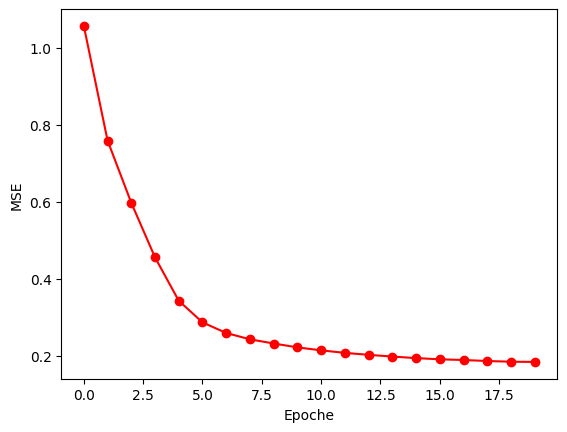

In [32]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

Calcoliamo MSE e R² sul validation set

In [33]:
model.evaluate(X_val, y_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.1887


0.19901758432388306

In [34]:
r2_score(y_val, model.predict(X_val))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.719952318812099

Grazie alla combinazione di nodi non lineari abbiamo ottenuto un modello nettamente migliore, come visibile anche dal grafico

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


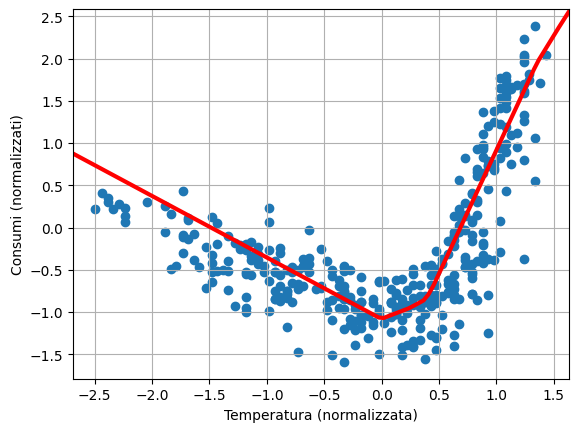

In [35]:
plot_model_on_data(X_val, y_val, model)

Col metodo `get_weights` possiamo ottenere i parametri del modello, scomposti in questo caso in

- una matrice 1x8 con i pesi dello strato nascosto
- un vettore con gli 8 bias dello strato nascosto
- una matrice 8x1 con i pesi del nodo di output
- un vettore con il bias del nodo di output

In [36]:
model.get_weights()

[array([[-0.8144503 ,  0.7515474 , -0.00291604, -0.70563847,  0.18119633,
          0.9555612 , -0.72388947, -0.6582187 ]], dtype=float32),
 array([-0.00144549, -0.3206515 , -0.0192336 ,  0.1688343 , -0.2803139 ,
        -0.3481779 , -0.00283582,  0.89099   ], dtype=float32),
 array([[ 0.77087754],
        [ 1.6651033 ],
        [ 0.16467053],
        [ 0.2826515 ],
        [-0.41621438],
        [ 0.99508154],
        [ 0.85861313],
        [-1.0945425 ]], dtype=float32),
 array([-0.1516383], dtype=float32)]

### Esercizio 1: Regressione in Keras

- **(1a)** Definire, addestrare e calcolare R² di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(1b)** Definire, addestrare e calcolare R² di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere prima di utilizzare `summary`)

In [38]:
# 1a (1*32 + 32 + 32*1 + 1 = 97 parametri)
model = Sequential([
    Input((1,)),
    Dense(32, activation="relu"),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.8961
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.4967
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.3030
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 0.2469
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.2011
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.2048
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.1911
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.1908
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.1988
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.1752
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.6777669589322952

In [39]:
# 1b (1*32 + 32 + 32*8 + 8 + 8*1 + 1 = 337 parametri)
model = Sequential([
    Input((1,)),
    Dense(32, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.9374
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.5065
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.2626
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.2023
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.1844
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.1784
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1748
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.1749
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1981
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.1807
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.6687608489089278

## Classificazione con reti neurali

Riprendiamo l'esempio della classificazione di punti nel piano con classi non separabili linearmente

- sia training che validation set contengono le coordinate di punti in un piano, distribuiti in due diverse corone circolari
- vogliamo addestrare un modello di classificazione a distinguere i punti interni da quelli esterni

In [40]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5, random_state=42)

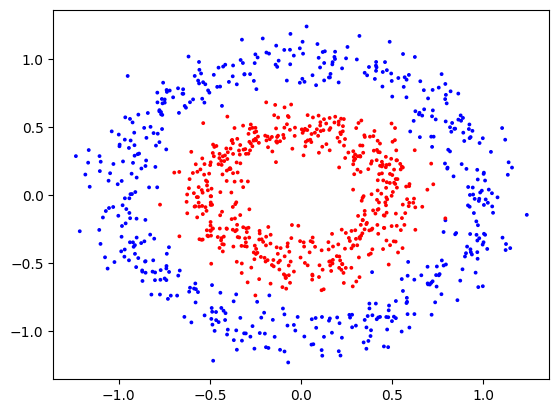

In [41]:
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

Riprendiamo la funzione che, dato un modello, visualizza come questo classifica i punti nel piano

In [42]:
def plot_class_model(X, y, model):
    plt.scatter(X[:, 0], X[:, 1])
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    if hasattr(model, "predict_proba"):  # modello scikit-learn
        mz = model.predict_proba(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    else:  # modello keras
        mz = model.predict(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

Abbiamo visto che un modello lineare non può essere addestrato efficacemente a distinguere le due classi per via della non linearità

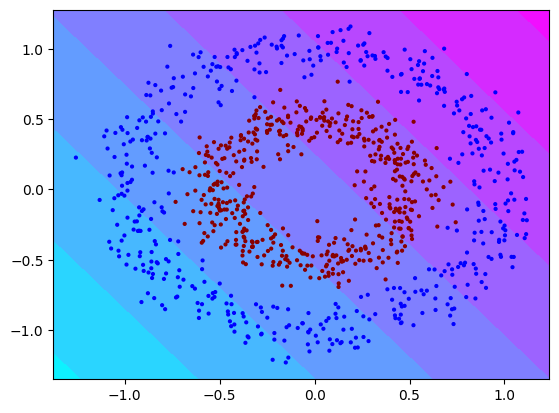

In [43]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

Se introduciamo manualmente i quadrati delle variabili, otteniamo un modello efficace

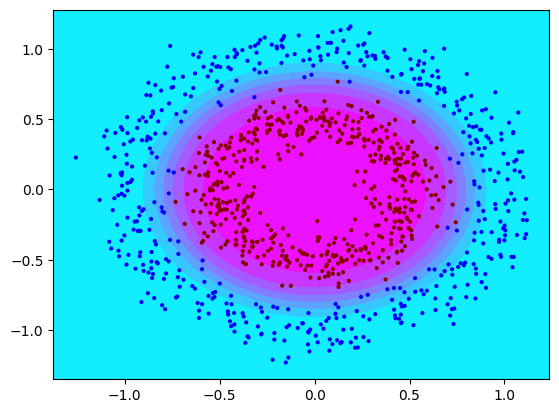

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

Abbiamo però visto come con una rete neurale, senza generare manualmente delle variabili, otteniamo lo stesso risultato

Consideriamo ad esempio una rete costituita da un singolo strato nascosto di 32 nodi con attivazione ReLU e addestrata con discesa gradiente stocastica (SGD) per 100 epoche a minibatch di 200 istanze

In [45]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(
    hidden_layer_sizes=[32],
    activation="relu",
    solver="sgd",
    max_iter=100,
    batch_size=200,
    random_state=123,
)
model.fit(X_train, y_train);

/home/pasolini/.venvs/dia/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


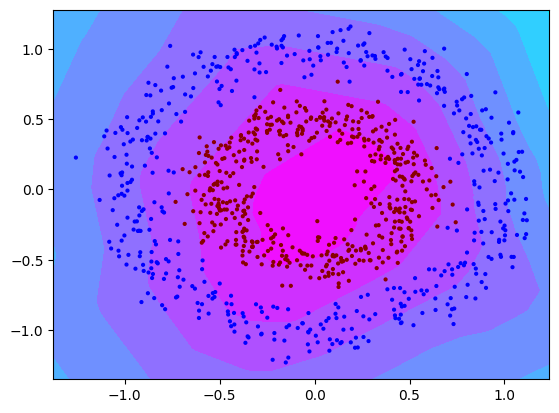

In [46]:
plot_class_model(X_val, y_val, model)

In [47]:
model.score(X_val, y_val)

0.955

La rete ha sfruttato i nodi per approssimare quanto meglio possibile la distribuzione delle classi

## Modello di classificazione in Keras

Vediamo ora come creare un modello di classificazione in Keras per capirne il funzionamento

Per suddividere oggetti in N classi (quì 2), creiamo una rete neurale con **molteplici nodi di output**, uno per ciascuna classe

NB: con sole due classi potremmo replicare un modello di regressione logistica con un singolo nodo di output, preferiamo però mostrare un approccio facilmente generalizzabile ad un qualsiasi numero di classi

Addestriamo quindi la rete in modo che il nodo di output corrispondente alla classe giusta dia un valore maggiore degli altri

Per questo l'output atteso della rete per ciascun input, per ora rappresentato come un singolo valore 0 o 1...

In [48]:
y_train[:5]

array([1, 1, 0, 1, 1])

...va rappresentato come un vettore _one-hot_ di due elementi, dove

- 0 (punti esterni) si codifica con `[1, 0]`
- 1 (punti interni) si codifica con `[0, 1]`

Questa rappresentazione è generalizzabile a qualsiasi numero di classi, ad es. la quarta di 5 classi sarebbe codificata con `[0, 0, 0, 1, 0]`

Keras fornisce un'apposita funzione `to_categorical` per codificare l'output in questo modo

In [49]:
from tensorflow.keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

Otteniamo così le coppie di valori corrispondenti ai valori attesi dei due nodi di output della rete in ciascun caso

In [50]:
yt_train[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Addestriamo un modello con uno strato nascosto di 8 nodi con attivazione ReLU

Nello strato `Input` specifichiamo che i valori in input sono 2, le coordinate del punto

Nello strato finale di output utilizziamo due nodi, **uno per classe**

La **funzione di attivazione `softmax`** fa in modo che l'output della rete costituisca una **distribuzione di probabilità tra le due classi**, ovvero che la somma dei due valori sia sempre 1

In [51]:
model = Sequential([
    Input((2,)),
    Dense(8, activation="relu"),
    Dense(2, activation="softmax"),
])

Nel modello abbiamo così un totale di 42 parametri

- 2x8 = 16 pesi e 8 bias nello strato nascosto
- 8x2 = 16 pesi e 2 bias nello strato di output

In [52]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

Per la classificazione, impostiamo `categorical_crossentropy` come misura dell'errore: l'errore è tanto più alto quanto più la probabilità stimata per la classe corretta si allontana da 100\%

In aggiunta alla metrica dell'errore da ottimizzare, possiamo aggiungere altre metriche di valutazione che vogliamo misurare (`metrics`): calcoliamo l'`accuracy`, ovvero la percentuale di esempi classificati correttamente

La rete sarà quindi addestrata per ridurre la `categorical_crossentropy`, ma verrà calcolata e mostrata anche la `accuracy`

In [53]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

Addestriamo quindi la rete, passando i valori in input (le coordinate dei punti) e quelli in output (le classi nel formato one-hot encoded)

In [54]:
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=20)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.5162 - loss: 0.6642
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.6141 - loss: 0.6462
[...]
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.9905 - loss: 0.2459
Epoch 20/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.9916 - loss: 0.2345


In `fit_history` troviamo salvato l'andamento sia dell'errore che dell'accuratezza sul training set

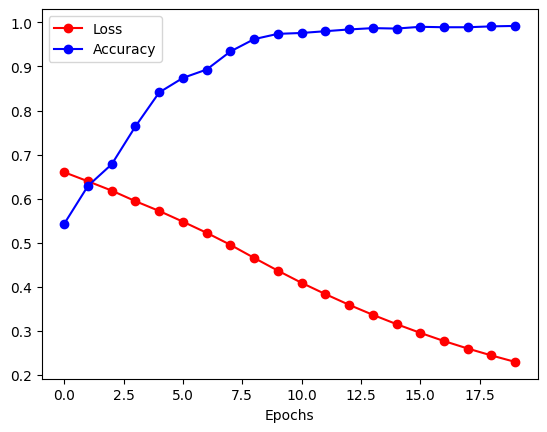

In [55]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

Con `predict` otteniamo l'output "grezzo" della rete a fronte di input dati, ovvero le probabilità delle due classi

In [56]:
model.predict(X_val[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.09548367, 0.9045163 ],
       [0.13016541, 0.86983454],
       [0.3507118 , 0.6492882 ],
       [0.20044823, 0.7995518 ],
       [0.8580109 , 0.14198904]], dtype=float32)

Per ottenere la classe predetta per ogni istanza (quella con probabilità maggiore) possiamo applicare `argmax` riga per riga

In [57]:
np.argmax(model.predict(X_val[:5]), -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([1, 1, 1, 1, 0])

Con `evaluate` calcoliamo tutte le misure indicate in `compile`, ovvero la cross entropy e l'accuratezza

In [58]:
model.evaluate(X_val, yt_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9921 - loss: 0.2292


[0.2259833812713623, 0.9900000095367432]

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


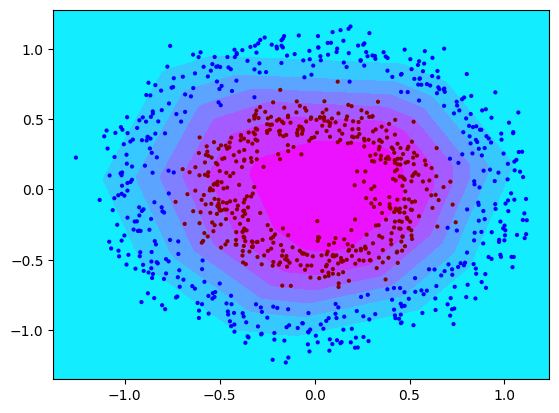

In [59]:
plot_class_model(X_val, y_val, model)

### Esercizio 2: Classificazione in Keras

- **(2a)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(2b)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere prima di utilizzare `summary`)

In [61]:
# 2a (2*32 + 32 + 32*2 + 2 = 162 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10


/home/pasolini/.venvs/dia/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.4644 - loss: 0.7379
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.4465 - loss: 0.6831
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.4866 - loss: 0.6532
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.5624 - loss: 0.6178
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7584 - loss: 0.5780
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.8918 - loss: 0.5447
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.9399 - loss: 0.4954
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.9647 - loss: 0.4415
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9757 - loss: 0.3907
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.9798 - loss: 0.3362
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.9847 - loss: 0.3148


[0.30849310755729675, 0.9890000224113464]

In [62]:
# 2b (2*32 + 32 + 32*8 + 8 + 8*2 + 2 = 378 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(8, activation="relu"),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.5277 - loss: 0.6666
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.5512 - loss: 0.6204
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7844 - loss: 0.5335
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.9698 - loss: 0.4011
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9935 - loss: 0.2433
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.9839 - loss: 0.1623
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.9972 - loss: 0.1050
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.9906 - loss: 0.0839
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.9921 - loss: 0.0619
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9926 - loss: 0.0528
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.9974 - loss: 0.0503


[0.048768673092126846, 0.9959999918937683]

## Caso di studio: Predizione vendite

Riprendiamo il caso di studio sui 1.000 negozi della catena europea Rossmann

La predizione su questi dati è stata oggetto di una competizione su Kaggle: https://www.kaggle.com/c/rossmann-store-sales

I dati che forniamo sono versioni già parzialmente preprocessate di quelli originali su Kaggle

Vogliamo prevedere le vendite del giorno per dimensionare adeguatamente magazzino, personale, ...

### Dataset

I dati sono forniti divisi in due file, per addestramento e validazione

In [63]:
download("rossmann_train.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_train.csv.gz")
download("rossmann_valid.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_valid.csv.gz")

Carichiamo i due file e vediamone la quantità di osservazioni

In [64]:
data_train = pd.read_csv(
    "rossmann_train.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [65]:
data_val = pd.read_csv(
    "rossmann_valid.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [66]:
len(data_train), len(data_val)

(804056, 40282)

Vediamo un estratto dei due frame

In [67]:
data_train.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,314,2015-06-19,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,164.0,22.50,0,562,5032
1,458,2015-06-19,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,688,7362
2,961,2015-06-19,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,768,7764
3,132,2015-06-19,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,24186.0,35.50,0,692,7964


In [68]:
data_val.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,1,2015-07-31,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75,0,555,5263
1,747,2015-07-31,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,83.0,24187.75,0,826,10708
2,772,2015-07-31,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,24187.0,24187.75,0,635,5224
3,752,2015-07-31,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,28.0,24.00,0,565,7763


### Descrizione variabili

- Ogni riga è un'osservazione relativa ad un singolo negozio in una certa data, indicati dalle colonne `Store` e `Date`
- Le ultime due colonne `Customers` and `Sales` indicano rispettivamente il numero di clienti e il ricavo totale delle vendite per quel giorno in quel negozio
- Le altre colonne riportano informazioni note a priori relative a negozio e giorno
  - applicazione di promozioni (`Promo*`, `IsPromoMonth`)
  - festività (`StateHoliday`, `SchoolHoliday`)
  - tipologia di negozio (`StoreType`, `Assortment`)
  - distanza da negozi concorrenti e loro data di apertura (`Competition*`)

L'obiettivo è prevedere da queste informazioni il ricavo totale (`Sales`)

Definiamo le serie `y_*` con i valori di `Sales` per training e validation set

In [69]:
y_train = data_train["Sales"]
y_val = data_val["Sales"]

Il ricavo totale `Sales` è ovviamente strettamente proporzionale al numero di clienti `Customers` (selezioniamo con `sample(N)` un numero limitato di campioni casuali per creare il grafico con più efficienza)

Non possiamo però usare la variabile `Customers` nella predizione, in quanto proprio come `Sales` non è un'informazione nota a priori

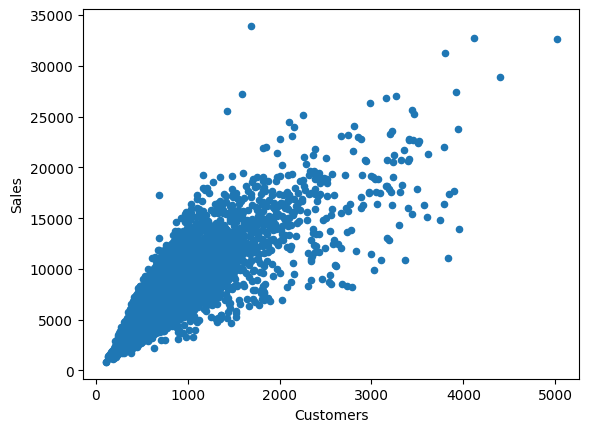

In [70]:
data_train.sample(10000).plot.scatter("Customers", "Sales");

### Selezione e preprocessamento delle variabili

Consideriamo tre gruppi di variabili da utilizzare per la predizione

- quelle con un valore propriamente numerico oppure binarie (0/1), che non richiedono preprocessing
  - distanza dalla concorrenza, da quanto tempo è in corso una promozione, ...
  - se sono in corso delle promozioni, se è giorno di chiusura delle scuole, ...
- quelle categoriche con più di 2 valori, a cui applichiamo il one-hot encoding
- la colonna della data `Date`, da cui vogliamo estrarre singoli campi (es. giorno della settimana)

In [71]:
numeric_cols = [
    "Promo", "SchoolHoliday", "CompetitionDistance",
    "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
    "Promo2", "Promo2SinceWeek", "Promo2SinceYear",
    "CompetitionOpen", "PromoOpen", "IsPromoMonth"
]

In [72]:
categorical_cols = ["StateHoliday", "StoreType", "Assortment"]

In [73]:
# funzione per l'estrazione dei campi data
def extract_date_fields(X):
    result = {}
    for col in X.columns:
        result[f"{col}_day"] = X[col].dt.day
        result[f"{col}_month"] = X[col].dt.month
        result[f"{col}_dayofweek"] = X[col].dt.dayofweek
    return pd.DataFrame(result)

Utilizziamo quindi un `ColumnTransformer` per combinare insieme tutte le colonne preprocessate opportunamente

- le colonne numeriche sono prese così come sono (_passthrough_)
- alle colonne categoriche è applicato il one-hot encoding
- dalla colonna `Date` sono estratti i componenti della data

Mettiamo questo filtro in pipeline con uno `StandardScaler` per standardizzare tutte le variabili

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
date_transformer = FunctionTransformer(extract_date_fields)
transformer = Pipeline([
    ("cols", ColumnTransformer([
        ("num" , "passthrough",    numeric_cols),
        ("cat" , OneHotEncoder(),  categorical_cols),
        ("date", date_transformer, ["Date"]),
    ])),
    ("scaler", StandardScaler()),
])

Applichiamo il filtro composito al training e al validation set; le colonne non specificate (`Sales` e `Customers`) sono scartate (_drop_) di default dal `ColumnTransformer`

In [75]:
X_train = transformer.fit_transform(data_train)
X_val = transformer.transform(data_val)

Eseguiamo infine la standardizzazione della variabile da predire (`Sales`) con un altro `StandardScaler`

In [76]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(data_train["Sales"].values[:, None]).ravel()
y_val = scaler_y.transform(data_val["Sales"].values[:, None]).ravel()

## Modelli di regressione sui dati Rossmann

Testiamo come baseline un modello di regressione lineare

In [77]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

Con `score` calcoliamo l'accuratezza calcolata col coefficiente R²

In [78]:
model.score(X_val, y_val)

0.2473851562927717

Nella competizione Kaggle viene usata come misura di riferimento il _Root Mean Squared Percentage Error_ (RMSPE)

$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$

Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni, avendo cura di riportare i valori standardizzati nella scala originale

In [79]:
def rmspe(y_real, y_pred):
    y_real = scaler_y.inverse_transform(y_real[:, None])
    y_pred = scaler_y.inverse_transform(y_pred[:, None])
    return np.sqrt(np.mean((y_pred/y_real-1) ** 2))

Il modello di regressione lineare ottiene un RMSPE pari a...

In [80]:
rmspe(y_val, model.predict(X_val))

0.49824787941314086

Vediamo i risultati che possiamo ottenere con le reti neurali: iniziamo da una rete con un singolo strato nascosto con attivazione ReLU

In [81]:
model = Sequential([
    # num. valori in input = num. colonne in X
    Input((X_train.shape[1],)),
    Dense(128, activation="relu"),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error")

In un problema reale come questo il numero di parametri da addestrare raggiunge facilmente l'ordine delle migliaia

In [82]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 5s 535us/step - loss: 0.7336
Epoch 2/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step - loss: 0.6437
Epoch 3/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 473us/step - loss: 0.6091
Epoch 4/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step - loss: 0.5904
Epoch 5/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step - loss: 0.5777


Dati dei valori in input, con `predict` otteniamo i valori predetti (normalizzati)

In [84]:
model.predict(X_val[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.49476966],
       [0.9129348 ],
       [0.25846335],
       [0.13824463],
       [0.5229311 ]], dtype=float32)

Calcoliamo l'RMSPE dalle predizioni come visto sopra

In [85]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


0.35096033933234244

Testiamo ora una rete con 3 strati nascosti con diversi numeri di nodi: ogni strato idealmente corrisponde ad una rappresentazione diversa dell'input

In [86]:
model = Sequential([
    Input((X_train.shape[1],)),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error")

Per via dei molteplici strati, il numero di parametri da addestrare aumenta sensibilmente

In [87]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,137 (324.75 KB)

 Trainable params: 83,137 (324.75 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6785
Epoch 2/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.4697
Epoch 3/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.3753
Epoch 4/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.3334
Epoch 5/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.3093


In [89]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step


0.2612103280304036

Siamo così riusciti a migliorare il RMSPE rispetto ai modelli di regressione semplici

I risultati sono ulteriormente migliorabili aumentando le epoche di addestramento

## Regolarizzazione

Nelle reti neurali si possono introdurre diversi accorgimenti per evitare l'overfitting

Come in altri modelli, possiamo utilizzare la regolarizzazione per evitare che i parametri del modello assumano valori elevati

I tipi di regolarizzazione applicabili sono `l2` (ridge), `l1` (lasso) o entrambe (elastic net)

La regolarizzazione può essere applicata sui pesi (_kernel_), sui bias e/o sull'output della funzione di attivazione (_activity_)

Nell'esempio seguente riprendiamo la rete con un singolo strato nascosto applicando la regolarizzazione L2 ai pesi

In [90]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Input((X_train.shape[1],)),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [91]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 5s 556us/step - loss: 0.7634
Epoch 2/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 554us/step - loss: 0.6681
Epoch 3/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 5s 590us/step - loss: 0.6423
Epoch 4/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 538us/step - loss: 0.6273
Epoch 5/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step - loss: 0.6175


In [92]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step


0.3707019803479087

## Dropout

Il _dropout_ è una tecnica usata nell'addestramento delle reti neurali per cui ad ogni batch in uno o più strati scelti vengono azzerati alcuni valori di input scelti casualmente

In questo modo la rete si addestra su informazioni incomplete, con possibile riduzione dell'overfitting

Riprendiamo come esempio la rete con tre strati nascosti usata sopra

Introduciamo dopo il primo strato nascosto uno strato `Dropout`, in cui specifichiamo la frazione di input da azzerare (ad es 10\%)

In [93]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Input((X_train.shape[1],)),
    Dense(512, activation="relu"),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

Lo strato dropout è "astratto", non introduce nuovi nodi o nuovi parametri da addestrare

In [94]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,137 (324.75 KB)

 Trainable params: 83,137 (324.75 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.6933
Epoch 2/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.5075
Epoch 3/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.4169
Epoch 4/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3680
Epoch 5/5
8041/8041 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3392


In [96]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step


0.26156931285017954

Si noti come l'errore sul training set rimanga leggermente più alto rispetto al modello senza dropout, ma il RMSPE sul validation set è simile

## Integrazione tra scikit-learn e Keras

Lavorando in scikit-learn abbiamo visto diversi strumenti utili per testare e ottimizzare i modelli di predizione (cross validation, grid search, ...)

È possibile riutilizzare gli stessi struenti su modelli Keras?

La libreria [SciKeras](https://github.com/adriangb/scikeras)_ fornisce le classi `KerasClassifier` e `KerasRegressor` che **incapsulano dei modelli Keras nell'API di scikit-learn**, permettendo così il loro uso all'interno ad es. di una grid search

In [97]:
#%pip install scikeras

Iniziamo definendo una funzione che restituisce un semplice modello Keras compilato ma non addestrato

In [98]:
def sample_net():
    model = Sequential([
        Input((X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

Creiamo quindi un oggetto `KerasRegressor`, a cui vanno passati come iperparametri

- una funzione `build_fn` come quella sopra che definisce la struttura della rete
- i parametri per l'addestramento, quali numero di epoche e batch size (usiamo quì parametri "scarsi" per ridurre i tempi)

In [99]:
from scikeras.wrappers import KerasRegressor
model = KerasRegressor(model=sample_net, epochs=3, batch_size=1000)

L'oggetto `KerasRegressor` fornisce l'API standard di scikit-learn, per cui possiamo addestrarlo con `fit` passando il training set... (gli altri parametri sono già passati al costruttore)

In [100]:
model.fit(X_train, y_train);

Epoch 1/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - loss: 0.9103
Epoch 2/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.7368
Epoch 3/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.7206


...e ottenere le predizioni con `predict`

In [101]:
y_pred = model.predict(X_val)
r2_score(y_val, y_pred)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


0.32174901403860323

La funzione che costruisce la rete può contenere dei parametri: qui ad esempio rendiamo il numero di nodi nello strato nascosto un parametro `nodes`

In [102]:
def sample_net(nodes):
    model = Sequential([
        Input((X_train.shape[1],)),
        Dense(nodes, activation="relu"),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

I valori dei parametri della funzione possono essere impostati come iperparametri nel costruttore di `KerasRegressor`

In [103]:
model = KerasRegressor(model=sample_net, model__nodes=32, epochs=3, batch_size=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
r2_score(y_val, y_pred)

Epoch 1/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - loss: 1.1868
Epoch 2/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.7279
Epoch 3/3
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.7099
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


0.3333665186550654

Questo permette una migliore integrazione con scikit-learn: in particolare possiamo effettuare una grid search sui parametri che influenzano la struttura della rete

In [104]:
from sklearn.model_selection import GridSearchCV, KFold

model = KerasRegressor(model=sample_net, epochs=3)
grid = {
    "model__nodes": [16, 32],
    "batch_size": [500, 1000],
}
gs = GridSearchCV(model, grid, cv=KFold(3, shuffle=True))
gs.fit(X_train, y_train)
gs.best_params_

Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.8973
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.7401
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 0.7259
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 1.1103
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.7387
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.7286
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - loss: 0.9824
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.7273
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.7088
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 0.8652
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.7246
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - loss: 0.7049
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s

{'batch_size': 500, 'model__nodes': 32}

## Proposte di esercizio

Testare sullo stesso problema altre configurazioni di reti neurali
- modificando il numero di strati e di nodi in essi
- introducendo diversi tipi di regolarizzazione con diversa intensità in diversi strati
- introducendo il dropout con diversa intensità in diversi strati
- cambiando il numero di epoche o la batch size

Consultare la [guida di Keras](https://keras.io/api/) per dettagli su queste e altre opzioni (altre funzioni di attivazione, inizializzazione dei pesi, algoritmi di ottimizzazione e relative opzioni, ...)

## Caso di studio: Riconoscimento attività umane

Gli smartphone moderni contengono diversi **sensori di movimento**, quali accelerometro e oscilloscopio

È possibile, raccogliendo dati da questi sensori, risconoscere **quale attività sta svolgendo una persona**? (È in piedi fermo? Sta camminando? È seduto? ...)

Vediamo come addestrare una rete neurale a riconoscere l'attività svolta da una sequenza di letture dei sensori

Tale rete può essere in seguito integrata in un'app per smartphone, ad es. per il tracking dell'attività fisica

### Dataset

Utilizziamo un set di dati di letture da sensori diponibile online su https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

Sono distinte **6 classi relative a diverse attività** o posizioni: camminare, salire scale, scendere scale, seduti, in piedi, sdraiati

Queste attività sono state svolte da 30 persone diverse mentre indossavano uno smartphone

50 volte al secondo sono stati campionati **9 valori** ottenuti da 3 sensori (accelerazione con e senza gravità, rotazione) a 3 assi (XYZ)

Il dataset finale ha **10.299 sequenze** (tra training e test), ciascuna contenente **128 campioni** di ciascuna delle 9 variabili, a ciascuna sequenza è associata una delle 6 classi

Scarichiamo il dataset in formato ZIP dal Web...

In [105]:
HAR_DATA_URL = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

download("HARDataset.zip", HAR_DATA_URL)

...ed estraiamo i file

In [106]:
from zipfile import ZipFile
if not os.path.isdir("UCI HAR Dataset"):
    with ZipFile("HARDataset.zip") as zipf:
        zipf.extractall()

I dati sono già divisi in due set `train` e `test`

Nella directory `Inertial Signals` di ciascuno si trovano i file con i dati grezzi ottenuti dai sensori

Sono considerati 3 diversi sensori:

- `total_acc`: accelerazione (accelerometro)
- `body_acc`: accelerazione senza la forza di gravità
- `body_gyro`: rotazione (giroscopio)

Per ogni sensore si considerano tre assi x, y, z come da figura:

![x da sinistra verso destra, y dal basso verso l'alto, z da dietro verso davanti](https://developer.android.com/images/axis_device.png)

La seguente funzione carica tutti i dati descritti sopra dai file estratti

In [107]:
def load_dataset(prefix, sensors):
    def load_file(filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values
    def load_dataset_group(group, prefix, sensors):
        filepath = prefix + group + "/Inertial Signals/"
        filenames = ["{}_{}_{}.txt".format(sensor, axis, group)
                     for sensor in sensors for axis in "xyz"]
        X_data = [load_file(filepath + name) for name in filenames]
        X = np.dstack(X_data)
        y = load_file(prefix + group + '/y_'+group+'.txt').ravel() - 1
        return X, y
    trainX, trainy = load_dataset_group('train', prefix, sensors)
    testX, testy = load_dataset_group('test', prefix, sensors)
    return trainX, trainy, testX, testy

Invochiamo la funzione, specificando i sensori per cui vogliamo caricare i dati (si può eventualmente usare solo una parte dei sensori, ad es. per smartphone dotati solo di alcuni di essi)

In [108]:
X_train, y_train, X_test, y_test = load_dataset(
    "UCI HAR Dataset/",
    ["total_acc", "body_acc", "body_gyro"]
)

Otteniamo due dataset "train" e "test", costituiti rispettivamente da 7.352 e da 2.947 osservazioni, ovvero sequenze raccolte in diversi momenti o da diverse persone

Gli array `X_*` a **3 dimensioni** (assi) contengono i valori campionati dai sensori

- lungo l'asse 0 abbiamo le **N sequenze**
- lungo l'asse 1 abbiamo i **128 istanti**
- lungo l'asse 2 abbiamo i **9 valori campionati** per ogni istante (3 sensori per 3 assi)

In pratica, il valore `X_train[i,j,k]` è il valore di indice k campionato all'istante j nella i-esima sequenza del training set

**Ciascuna istanza** di training e di test set è quindi **rappresentata con una matrice a 2 dimensioni** piuttosto che con un vettore come visto finora

In [109]:
X_train.shape

(7352, 128, 9)

In [110]:
X_test.shape

(2947, 128, 9)

Gli array `y_*` a 1 dimensione contiene le etichette delle finestre temporali, le etichette sono comprese tra 0 e 5

In [111]:
y_train.shape

(7352,)

In [112]:
y_test.shape

(2947,)

Carichiamo dal file `activity_labels.txt` i nomi delle attività riconosciute

In [113]:
with open("UCI HAR Dataset/activity_labels.txt", "rt") as f:
    labels = [line.split(" ")[1].strip() for line in f]

In [114]:
labels

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

Possiamo usarle per vedere la distribuzione di osservazioni delle diverse attività in training e test set

In [115]:
pd.Series(labels)[y_train].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
dtype: int64

In [116]:
pd.Series(labels)[y_test].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
dtype: int64

Codifichiamo le etichette (y) in vettori one-hot da usare come output atteso della rete

In [117]:
from tensorflow.keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_test = to_categorical(y_test)

I valori in ingresso hanno già media vicina a 0 e dev. standard contenuta, non è necessario standardizzarli

In [118]:
X_train.mean((0, 1))

array([ 8.04749279e-01,  2.87554865e-02,  8.64980163e-02, -6.36303058e-04,
       -2.92296856e-04, -2.75299412e-04,  5.06464674e-04, -8.23780831e-04,
        1.12948439e-04])

In [119]:
X_train.std((0, 1))

array([0.41411195, 0.39099543, 0.35776881, 0.19484634, 0.12242748,
       0.10687881, 0.40681506, 0.38185432, 0.25574314])

Dalle dimensioni degli array ricaviamo

- il numero di campioni per ogni sequenza (128)
- il numero di valori per ogni campione (9)
- il numero di possibili classi (6)

In [120]:
n_timesteps = X_train.shape[1]  # = 128
n_features = X_train.shape[2]   # = 9
n_outputs = yt_train.shape[1]   # = 6

Costruiamo una prima rete per la classificazione con un singolo strato nascosto

L'input del modello è una **matrice 128x9**, ovvero il numero di campioni in una sequenza per il numero di valori in ciascuno

Dopo l'input inseriamo uno strato `Flatten` per convertire ciascuna matrice in un **vettore di 128*9 = 1.152 elementi**: questo strato **cambia la rappresentazione dei dati** per renderla compatibile con gli strati `Dense`, che si aspettano un vettore per ogni istanza, **non** vengono aggiunti nodi o parametri da addestrare

Essendo un problema di classificazione, in output usiamo uno strato con **attivazione softmax con 6 nodi, uno per classe**

In [121]:
from tensorflow.keras.layers import Flatten

model = Sequential([
    Input((n_timesteps, n_features)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(n_outputs, activation="softmax"),
])

Vediamo la struttura della rete con la forma dell'output e il numero di parametri per ogni strato

In [122]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,094 (144.90 KB)

 Trainable params: 37,094 (144.90 KB)

 Non-trainable params: 0 (0.00 B)

Come visto le altre volte, compiliamo il modello specificando

- di utilizzare l'algoritmo di ottimizzazione _Adam_ (variante della discesa gradiente stocastica)
- di ottimizzare (minimizzandola) la _categorical cross entropy_, tanto più alta quanto più le probabilità date alle classi corrette si allontanano dal 100\%
- di calcolare in parallelo anche l'accuratezza (percentuale di classificazioni corrrette)

In [123]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Addestriamo quindi il modello con `fit`, specificando

- il training set (input e relativi output attesi)
- il numero di epoche di addestramento
- la _batch size_, il numero di osservazioni (finestre temporali) in ciascun minibatch di addestramento

In [124]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.6386 - loss: 0.9940
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.8953 - loss: 0.3423
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.9321 - loss: 0.2175
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.9391 - loss: 0.1683
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.9482 - loss: 0.1448
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.9461 - loss: 0.1336
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.9538 - loss: 0.1146
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9508 - loss: 0.1133
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9606 - loss: 0.1008
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.9550 - loss: 0.1081
CPU times: user 4.9 s, sys: 777 ms, total: 5.68 s
Wall time: 3.09 s


Usiamo _evaluate_ per calcolare sul validation set le stesse metriche di valutazione mostrate sul training set durante l'addestramento

In [125]:
model.evaluate(X_test, yt_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8329 - loss: 0.5552


[0.4511772096157074, 0.8669833540916443]

L'accuratezza (il secondo numero) assume valori indicativamente tra 85\% e 90\% (suscettibili di casualità)

Salviamo questo modello in una variabile a parte per vedere successivamente come esportarlo...

In [126]:
model_to_export = model

Possiamo aggiungere uno strato nascosto per rendere più accurata la rete

In [127]:
model = Sequential([
    Input((n_timesteps, n_features)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax"),
])

Si noti che il numero di parametri da addestrare si alza sensibilmente...

In [128]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,230 (610.27 KB)

 Trainable params: 156,230 (610.27 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [130]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7315 - loss: 0.7609
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9332 - loss: 0.1870
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1335
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9526 - loss: 0.1137
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9522 - loss: 0.1095
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9581 - loss: 0.0993
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9531 - loss: 0.1023
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9583 - loss: 0.0899
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9619 - loss: 0.0834
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9569 - loss: 0.1011
CPU times: user 12.1 s, sys: 1.95 s, total: 14 s
Wall time: 5.34 s


In [131]:
model.evaluate(X_test, yt_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8296 - loss: 0.7095


[0.5894941687583923, 0.8802171945571899]

## Reti convoluzionali

Negli input delle reti neurali è spesso necessario **riconoscere dei pattern** che possono essere presenti **in diverse porzioni** dell'input

- nel caso comune delle immagini, si vogliono riconoscere dei particolari **indipendentemente dal punto in cui si trovano**
- nel caso di studio corrente, potremmo riconoscere delle brevi sequenze temporali di valori che sono peculiari di attività specifiche

Le reti _convoluzionali_ utilizzano strati con connessioni "locali" e pesi condivisi

- ogni nodo riceve input solamente **da nodi vicini tra loro** nello strato inferiore, assumendo che corrispondano a **porzioni di spazio o di tempo**
- **gli stessi pesi sono applicati a tutti i nodi**, in modo lo stesso pattern sia cercato sull'intero intervallo di spazio o di tempo analizzato

Inseriamo all'inizio della rete uno strato `Conv1D` impostando il numero e la lunghezza dei pattern da cercare: ad esempio poniamo di cercare parallelamente **16 pattern** con lunghezza di **15 passi temporali** ciascuno

L'input atteso dallo strato `Conv1D` per ogni osservazione è una matrice MxN con una sequenza di M campioni di N valori indipendenti ("canali"): i set di dati che utilizziamo hanno già questo formato, possono essere dati in input direttamente

L'output per ogni osservazione sarà una matrice MxN che indica in che misura ciascuno degli N pattern è stato individuato in ciascuno degli M punti dell'input; come sopra, applichiamo `Flatten` ad esso per convertire ciascuna matrice in un vettore lineare di nodi

In [132]:
from tensorflow.keras.layers import Conv1D

model = Sequential([
    Input((n_timesteps, n_features)),
    Conv1D(16, 15),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax"),
])

Dal sommario, vediamo che lo strato convoluzionale ha un numero di parametri nettamente inferiore rispetto ad un tipico strato denso: per ognuno dei 16 pattern abbiamo 15x9 pesi e un bias condivisi su 114 nodi, per un totale di 2.176 parametri

Lo strato restituisce 114x16 valori, ovvero 16 pattern cercati nelle 114 (128-15+1) sequenze possibili di 15 valori su 128

In [133]:
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 114, 16)        │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1824)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │       116,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,366 (466.27 KB)

 Trainable params: 119,366 (466.27 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [135]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7074 - loss: 0.8058
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9115 - loss: 0.2316
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9355 - loss: 0.1701
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9423 - loss: 0.1565
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9421 - loss: 0.1366
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9557 - loss: 0.1094
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9616 - loss: 0.0956
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9580 - loss: 0.0928
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9470 - loss: 0.1446
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9454 - loss: 0.1288
CPU times: user 15.3 s, sys: 2.21 s, total: 17.5 s
Wall time: 6.06 s


In [136]:
model.evaluate(X_test, yt_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.8639 - loss: 0.6618


[0.5726852416992188, 0.8965049386024475]

## Reti ricorrenti

Al contrario delle reti viste finora, una rete _ricorrente_ contiene connessioni cicliche tra nodi

A queste reti ciascun input è una sequenza fornita **in più passi temporali**: nel nostro caso, si immagini di fornire le 128 letture dei sensori **una dopo l'altra** invece che in blocco

Tramite le connessioni cicliche, **la rete mantiene uno stato** da un passo all'altro

L'output della rete ad un passo $t$ dipende sia dall'input allo stesso passo $t$ che dallo stato che si è creato in seguito agli input precedenti

Per usare una rete ricorrente, nei dati di addestramento e test deve essere presente **una dimensione temporale**: questo è il nostro caso, dove ogni osservazione è una sequenza di 128 campioni

Le reti ricorrenti possono potenzialmente riconoscere correlazioni tra dati forniti in passi temporali diversi, anche distanti

Keras fornisce diversi tipi di strati ricorrenti, tra cui le _Gated Recurrent Unit_ (GRU): ad ogni passo temporale $t$ lo strato GRU calcola un output di N valori $h(t)$ in funzione sia dell'input attuale $x(t)$ che dell'output precedente $h(t-1)$

In addestramento e test, dobbiamo fornire le osservazioni complete di tutti gli istanti temporali: ciascuna osservazione è una matrice MxN, rappresentante una sequenza di durata M di vettori di misura N (nel nostro caso, sequenze di 128 campioni di 9 valori)

Di default, solo l'output di GRU all'ultimo passo temporale è considerato per determinare l'output dato dalla rete ad ogni osservazione: questo output è un vettore che può essere passato direttamente ad uno strato `Dense`

In [137]:
from tensorflow.keras.layers import GRU
model = Sequential([
    Input((n_timesteps, n_features)),
    GRU(64, activation="relu"),
    Dense(n_outputs, activation="softmax"),
])

Anche in questo caso il numero di parametri è molto inferiore rispetto ad un MLP ordinario, in quanto gli stessi pesi vengono riutilizzati attraverso i 128 passaggi temporali

In [138]:
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,790 (57.77 KB)

 Trainable params: 14,790 (57.77 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Il tempo per l'addestramento aumenta, in quanto l'errore su ciascuna osservazione va derivato attraverso i 128 passi temporali (_backpropagation through time_)

In [140]:
%time model.fit(X_train, yt_train, epochs=5, batch_size=100)

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3818 - loss: 1.6698
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6024 - loss: 1.1555
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7298 - loss: 0.7110
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7924 - loss: 0.5033
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8290 - loss: 0.4015
CPU times: user 45.2 s, sys: 2.14 s, total: 47.4 s
Wall time: 18.7 s


In [141]:
model.evaluate(X_test, yt_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7583 - loss: 0.6696


[0.642802357673645, 0.7919918298721313]

## Deployment del modello con TensorFlow Lite

- TensorFlow Lite è un framework per il deep learning destinato a dispositivi mobili ed embedded
- Si usa per eseguire inferenze (stime e predizioni) su modelli che vengono caricati già addestrati sul dispositivo
  - l'inferenza richiede generalmente molte meno risorse rispetto all'addestramento
- Sul Web esistono diversi modelli preaddestrati per diversi task
  - riconoscimento immagini, natural language processing, ...
- Possiamo in aggiunta esportare i modelli addestrati con TensorFlow (anche tramite Keras)
- Nel nostro caso di studio, possiamo esportare il modello che riconosce le attività, per poi utilizzarlo ad es. all'interno di un'app mobile

### Esportazione del modello

- Creiamo un oggetto `TFLiteConverter` passando il modello Keras addestrato
  - NB: funziona solo su modelli che usano il package `tensorflow.keras`

In [142]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_export)

- Utilizziamone il metodo `convert` per ottenere la rappresentazione binaria
  - NB: eseguendo da Jupyter, si ha errore se TensorFlow è installato in un ambiente virtuale diverso da quello di Jupyter

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp4r1dy779/assets


- Esportiamo quindi tale rappresentazione in un file

In [ ]:
with tf.io.gfile.GFile("model.tflite", "wb") as f:
    f.write(tflite_model)

### Uso all'interno di un'app Android

- Vediamo in breve come si integra il modello esportato in un'app Android
- Per iniziare, dichiariamo TensorFlow Lite come dipendenza nel file `build.gradle` del progetto

```groovy
repositories {
  // ... altre repository ...
  maven {
    url 'https://google.bintray.com/tensorflow'
  }
}
dependencies {
  // ... altre dipendenze ...
  implementation 'org.tensorflow:tensorflow-lite:+'
}
```

- Un modello TF Lite è rappresentato a run-time da un oggetto `Interpreter`
- Creiamo tale oggetto passando un riferimento al file o direttamente un buffer con i dati
  - si può trattare di un file salvato nel file system, es. scaricato da Web
  - si può anche integrare il modello nell'app (nel file APK), configurandolo in modo che non venga compresso
- L'oggetto va generalmente creato all'apertura dell'app (`Activity.onCreate`) e chiuso col metodo `close` alla terminazione (`Activity.onDestroy`)

```java
import org.tensorflow.lite.Interpreter;
...
File modelFile = new File("/path/to/model.tflite");
Interpreter model = new Interpreter(modelFile);
```

- Per usare il modello vanno allocati per i suoi input e output dei buffer delle giuste dimensioni, che possono essere
  - degli array Java (come da esempio sotto)
  - oggetti `ByteBuffer` (meno immediati da usare ma più efficienti)

```java
// array 2D dove inserire l'input da passare alla rete
float[][] inputBuffer = new float[seqLength][inputSize];
// array in cui verrà scritto l'output della rete
float[] outputBuffer = new int[numClasses];
```

- Ogni volta che si vuole eseguire l'inferenza si usa il metodo `run` dell'`Interpreter`

```java
model.run(inputBuffer, outputBuffer);
```

- Nel nostro caso di studio, possiamo usare l'API `SensorManager` di Android per eseguire una callback ogni volta che arrivano dati dai sensori
- La callback andrà a riportare i dati ricevuti nel buffer di input e ad invocare il modello quando questo viene riempito

```java
void feedSensorData(int sensor, SensorEvent event) {
  // determina a quale passo temporale
  // si riferiscono i dati ricevuti
  int timestep = ...;
  // copia i dati del sensore nel buffer
  System.arraycopy(event.values, 0, inputBuffer[inputFillStep],
      NUM_AXES * sensor, NUM_AXES);
  // se sono arrivato al termine del buffer...
  boolean bufferIsFull = ...;
  if (bufferIsFull) {
    // esegui l'inferenza
    inferActivity();
    // azzera il buffer di input
    resetInputBuffer();
  }
}
```

- Quando il buffer è pieno, si passa il contenuto al modello, si ottengono le probabilità delle classi e si verifica qual è la più probabile

```java
int argmax(float[] values) {
  /** Restituisci indice del valore maggiore. */ ...
}

void inferActivity() {
  // eseguo l’inferenza con i dati raccolti
  model.run(inputBuffer, outputBuffer);
  // verifico la classe con probabilità maggiore
  int activityClass = argmax(outputBuffer);
  // invoco una callback (ad es. per aggiornare la GUI)
  callback.activityInferred(activityClass);
}
```